Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from custom_functions import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import dataset that was cleaned and prepared in Data Preparation notebook

In [4]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM step2_encoded'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
conn.close()

df_main.head(3)
y = 'SalePrice'
df_y = pd.DataFrame(df_main[y])

In [5]:
# Split all data columns into 'categorical' and 'continuous'
x_cat_vs_cont = {'categorical': ['DaylightBasement', 'HeatSystem', 'HeatSource', 'ViewUtilization', 'forced_air_vs_other'], 
                 'discrete': ['BldgGrade', 'Condition', 'Stories', 'NbrLivingUnits', 'FinBasementGrade', 'Bedrooms', 'Bathrooms', 'Fireplaces'],
                 'continuous': ['SqFtTotLiving', 'SqFtTotBasement', 'SqFtGarageAttached','SqFtOpenPorch', 
                             'SqFtEnclosedPorch', 'SqFtDeck','BrickStone', 'YrBuilt', 'YrRenovated', 'SqFtUnfinished']}

In [6]:
def produce_model(df, x, y, devct=3, drop_zeros=False):
    model_data = pd.concat([df[y], df[x]], axis=1)
    model_data_trimmed = remove_df_extremes(model_data, devct, drop_zeros)
    formula = y + ' ~ ' + '+'.join(x)
    model = ols(formula, model_data_trimmed).fit()
    print('Modeling:', formula)
    return model, model_data_trimmed

In [7]:
def qq(df, col):
    plt.figure(figsize=(12,6));
    sm.graphics.qqplot(df[col], line='45', fit=True)
    plt.title(f'Normality Assumption Check: QQ plot of {col} values');

In [8]:
def dist(df, x):
    plt.figure(figsize=(12,6));
    sns.distplot(df[x])
    plt.title(f'Distribution of {x} (KDE)')

In [9]:
def scatter(df, x, model):
    plt.figure(figsize=(12, 6));
    sns.lmplot(data = df, x=x, y=y, line_kws={'color':'r'})    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'Linearity Assumption: {x} vs. {y}');

In [8]:
# STEPWISE SELECTOR
non_na = df_main.dropna()
X = non_na.drop(y, axis=1)
Y = non_na[y]
results = stepwise_selection(X, Y, verbose=False)
#results

In [22]:
exclude_these_features = [y, 'ViewUtilization', 'DaylightBasement'] # Too many na's to justify
xs = df_main.drop(exclude_these_features, axis=1).columns

model, df_trimmed = produce_model(df_main, xs, y, 3)
x = 'Fireplaces'


sm.graphics.plot_regress_exog(model, x, fig=plt.figure(figsize=(15,8)));

#model.summary()

# qq(df_trimmed, x);
# dist(df_trimmed, x)
# scatter(df_trimmed, x, model)

SalePrice ~ NbrLivingUnits+Stories+BldgGrade+SqFtTotLiving+SqFtTotBasement+FinBasementGrade+SqFtGarageAttached+SqFtOpenPorch+SqFtEnclosedPorch+SqFtDeck+HeatSystem+HeatSource+BrickStone+Bedrooms+YrBuilt+YrRenovated+Condition+forced_air_vs_other+SqFtUnfinished+Bathrooms+Fireplaces


In [23]:
# CorrMatrix = df_trimmed.iloc[:, :10].corr()
# plt.figure(figsize=(15,10))
# sns.heatmap(CorrMatrix, annot=True)
# plt.title('Correlation Matrix for First 10 Features');

# CorrMatrix = pd.concat([df_trimmed[y], df_trimmed.iloc[:, 10:20]], axis=1).corr()
# plt.figure(figsize=(15, 10))
# sns.heatmap(CorrMatrix, annot=True)
# plt.title('Correlation Matrix for Next 10 Features')

# CorrMatrix = pd.concat([df_trimmed[y], df_trimmed.iloc[:, 20:]], axis=1).corr()
# plt.figure(figsize=(15, 10))
# sns.heatmap(CorrMatrix, annot=True)
# plt.title('Correlation Matrix for Remaining Features');

In [24]:
# model.summary()

In [25]:
#pd.plotting.scatter_matrix(df_main, figsize=(30,30));

In [26]:
# # Plot Histograms

# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20))

# for col, ax in zip(df_trimmed.columns, axes.flatten()):
#     ax.hist(df_trimmed[col])
#     ax.set_title(col)

In [27]:
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & (correlations.level_1 != 'SalePrice')]
correlations[0] = correlations[0].abs()
correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']

correlations.sort_values(by='Correlation (abs)', ascending=False, inplace=True)
correlations.reset_index(inplace=True, drop=True)
listed = list(correlations.loc[correlations['Correlation (abs)'] > 0.1].Feature.values)


#df_main[listed]

In [ ]:
# DEFINE BASELINE MODEL???

model_temp, df_temp = produce_model(df_main, ['SqFtTotLiving'], 'SalePrice', 3, drop_zeros=False)
model_temp.summary()

# Check Assumptions

In [195]:
model, df = produce_model(df_main, ['SqFtTotLiving', 'YrBuilt'], y, 3, drop_zeros=False)
linearity(model, df, supress_figures=True);
normality(model, df);
homoscedacity(model, df);
independence(model, df, supress_figures=True);

Modeling: SalePrice ~ SqFtTotLiving+YrBuilt
Linearity p-value (where null hypothesis = linear): 0.19618574794131877
Normality of Residuals (where null hypothesis = normality): JB stat=7520.704809998598, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=8.816413363763483e-295 and f-value's p-value=1.2472725080516676e-306
         Feature       VIF
0  SqFtTotLiving  7.455781
1        YrBuilt  7.455781


In [188]:
def linearity(model, df, supress_figures=False):
    lr = linear_rainbow(model)
    p = lr[1]
    print('Linearity p-value (where null hypothesis = linear):', p)
    
    if supress_figures == False:
        sns.pairplot(df)
        plt.suptitle('Investigating Linearity of Inputs', y=1.05)
    return p

In [149]:
def normality(model, df, plot_feature=False):
    jb = sms.jarque_bera(model.resid)
    print('Normality of Residuals (where null hypothesis = normality): JB stat={}, JB stat p-value={}'.format(jb[0], jb[1]))
    
    if plot_feature != False:
        sm.graphics.qqplot(df[plot_feature], line='45', fit=True)
        plt.title('Normality of Residuals:', col);
    return jb[0], jb[1]    
    

In [179]:
def homoscedacity(model, df, plot_feature=False):
    bp = het_breuschpagan(model.resid, model.model.exog)
    p_lm, p_f = bp[1], bp[3]
    print("Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value={} and f-value's p-value={}".format(p_lm, p_f))
    
    if plot_feature != False:
        predicted = model.predict()
        error = df[y] - predicted
        plt.scatter(df[plot_feature], error, alpha=0.3, )
        plt.plot([df[plot_feature].min(), df[plot_feature].max()], [0,0], color='black')
        plt.xlabel(plot_feature)
        plt.ylabel("Error (Actual-Predicted)")
        plt.title('Homoscedacity of Residuals');
    return p_lm, p_f

In [194]:
# CITATION: function content taken from Flatiron School Study Group material
def independence(model, df, supress_figures=False):
    features = df.drop(y, axis=1).columns
    
    df_vif = pd.DataFrame()
    df_vif['Feature'] = features
    df_vif['VIF'] = [variance_inflation_factor(df.drop(y, axis=1).values, i) for i in range (len(features))]
    
    if supress_figures == False:
        CorrMatrix = df.corr()
        #plt.figure(figsize=(15,10))
        sns.heatmap(CorrMatrix, annot=True)
    print(df_vif)
    return df_vif

In [138]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     5708.
Date:                Sun, 07 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:26:04   Log-Likelihood:            -2.4676e+05
No. Observations:               17638   AIC:                         4.935e+05
Df Residuals:                   17635   BIC:                         4.935e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.799e+06    1.5e+05     25.297      0.000     3.5e+06    4.09e+06
SqFtTotLiving   297.3472      2.810    105.826      0.000     291.840     302.855
YrBuilt       -1864.0162     77.058    -24.190      0.000   -2015.058   -1712.975
==============================================================================
Omnibus:                     3136.260   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7520.705
Skew:                           1.004   Prob(JB):                         0.00
Kurtosis:                       5.491   Cond. No.                     2.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

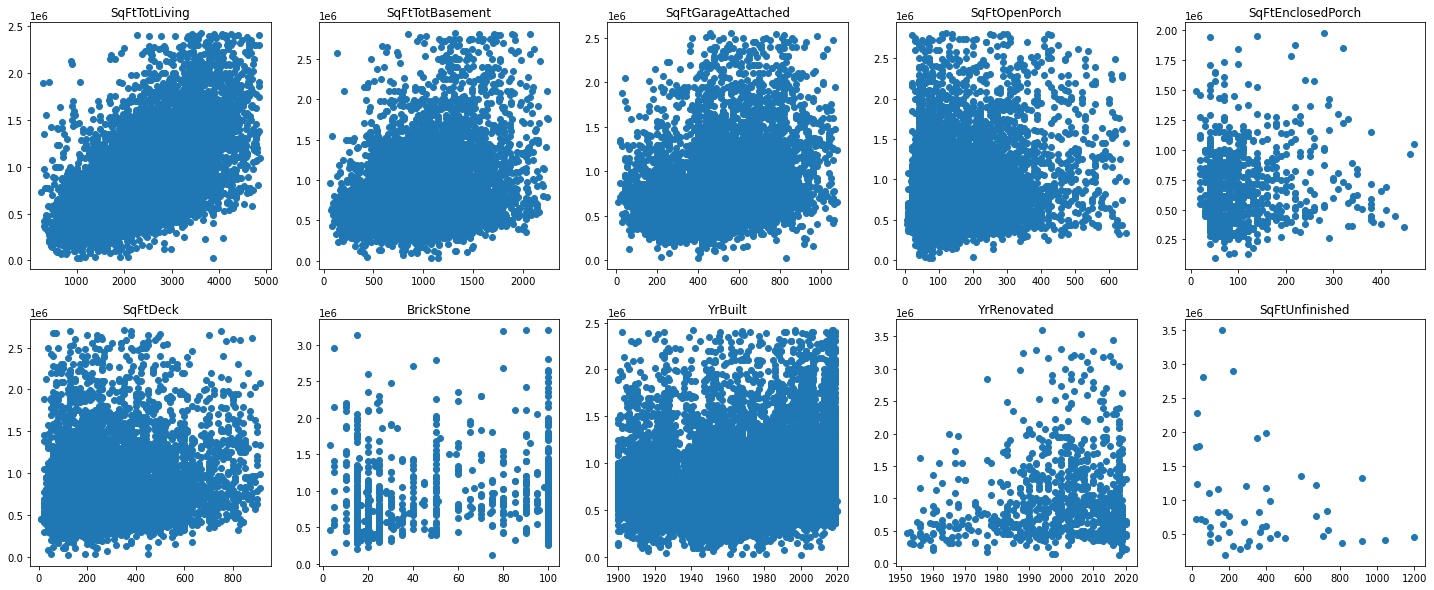

In [87]:


fig, axes = plt.subplots(2, 5, figsize=(25,10))

df_x_continuous = df_main[x_cat_vs_cont['continuous']].copy()
for col, ax in zip(df_x_continuous.columns, axes.flatten()):
    df = pd.concat([df_y, df_x_continuous[col]], axis=1)
    cleaned = remove_df_extremes(df, devct=3, drop_zeros=True)
    ax.scatter(y = y, x = col, data=cleaned)
    ax.set_title(col)
    

    
    